In [275]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from os import listdir
from tqdm import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

intput_path = "../input/"
output_path = "../output/"

In [ ]:
# df = pd.read_csv(output_path+"nn_aug_92303_12_test.csv")
# np.save(output_path+"nn_aug_92303_12_test.npy",df.target)

In [276]:
npys = [f for f in sorted(listdir(output_path)) if f.endswith("_oof.npy") and f[0]!="!" and "nn" in f]
npys

['nn_0.9163_oof.npy',
 'nn_0_0.92162_oof.npy',
 'nn_0_0.92191_oof.npy',
 'nn_0_0.92225_oof.npy',
 'nn_0_0.92226_oof.npy',
 'nn_0_0.92269_oof.npy',
 'nn_0_0.9229_oof.npy',
 'nn_0_0.92345_oof.npy',
 'nn_1_0.92213_oof.npy',
 'nn_1_0.92217_oof.npy',
 'nn_1_0.92266_oof.npy',
 'nn_1_0.92273_oof.npy',
 'nn_1_0.92294_oof.npy',
 'nn_1_0.923_oof.npy',
 'nn_2_0.92013_oof.npy',
 'nn_2_0.92128_oof.npy',
 'nn_2_0.9228_oof.npy',
 'nn_2_0.92314_oof.npy',
 'nn_3_0.91834_oof.npy',
 'nn_3_0.92114_oof.npy',
 'nn_3_0.92172_oof.npy',
 'nn_3_0.92235_oof.npy',
 'nn_3_0.92269_oof.npy',
 'nn_3_0.92287_oof.npy',
 'nn_4_0.92096_oof.npy',
 'nn_4_0.9227_oof.npy',
 'nn_4_0.92292_oof.npy',
 'nn_5_0.92241_oof.npy',
 'nn_5_0.92258_oof.npy',
 'nn_5_0.92286_oof.npy',
 'nn_5_0.92289_oof.npy',
 'nn_aug_0.92303_12_oof.npy']

In [277]:
path = "../kaggle-santander-ctp-2019/predictions/train/"
csvs = [f for f in sorted(listdir(path)) if f.endswith(".csv")][-10:-1]
csvs

['9202_separate_feature_models_threshold_0.84_10fold_04042353.csv',
 '9210_lightgbm_multiplied_counter_10_folds_0604220718.csv',
 '9211_catboost_unbalanced_weights_0304111611.csv',
 '9211_catboost_unique_with_10x_upsample_3103172847.csv',
 '9211_xgboost_multiplied_counter_10_folds_0604015413.csv',
 '9212_catboost_unique_10x_upsample_5_balancer_0204172825.csv',
 '9215_catboost_unique_10x_upsample_3_balancer_0204145755.csv',
 '9218_catboost_multiplied_counter_0304011056.csv',
 '9222_catboost_multiplied_counter_10_folds_0504034846.csv']

In [278]:
scaler = StandardScaler() #MinMaxScaler StandardScaler

dt = pd.DataFrame()

df = pd.read_csv(intput_path+'train.csv.zip')
df = df[["target"]]

cols = []
for file in tqdm(npys):
    train = np.load(output_path+file).reshape(-1, 1)
    col = file[:-4]
    cols.append(col)
    df[col] = scaler.fit_transform(train)
    df[col] = df[col].rank()/len(df)
    
    test = np.load(output_path+file.replace("_oof.npy","_test.npy")).reshape(-1, 1)
    dt[col] = [x[0] for x in scaler.transform(test)]
    dt[col] = dt[col].rank()/len(dt)
    
for file in tqdm(csvs):
    train = pd.read_csv(path+file)["target"].values.reshape(-1, 1)
    col = file[:-4]
    cols.append(col)
    df[col] = scaler.fit_transform(train)
    df[col] = df[col].rank()/len(df)
    
    test = pd.read_csv((path+file).replace("/train/","/test/"))["target"].values.reshape(-1, 1)
    dt[col] = [x[0] for x in scaler.transform(test)]
    dt[col] = dt[col].rank()/len(dt)
    
df["avg"] = df[cols].mean(axis=1)
dt["avg"] = dt[cols].mean(axis=1)

dt.tail()

100%|██████████| 9/9 [00:04<00:00,  2.09it/s]


,nn_0.9163_oof,nn_0_0.92162_oof,nn_0_0.92191_oof,nn_0_0.92225_oof,nn_0_0.92226_oof,nn_0_0.92269_oof,nn_0_0.9229_oof,nn_0_0.92345_oof,nn_1_0.92213_oof,nn_1_0.92217_oof,...,9202_separate_feature_models_threshold_0.84_10fold_04042353,9210_lightgbm_multiplied_counter_10_folds_0604220718,9211_catboost_unbalanced_weights_0304111611,9211_catboost_unique_with_10x_upsample_3103172847,9211_xgboost_multiplied_counter_10_folds_0604015413,9212_catboost_unique_10x_upsample_5_balancer_0204172825,9215_catboost_unique_10x_upsample_3_balancer_0204145755,9218_catboost_multiplied_counter_0304011056,9222_catboost_multiplied_counter_10_folds_0504034846,avg
199995,0.616195,0.714505,0.718645,0.722255,0.673865,0.678235,0.688590,0.707060,0.679740,0.67967,...,0.660345,0.713650,0.69927,0.701005,0.748400,0.668475,0.700525,0.75771,0.763175,0.702241
199996,0.417985,0.397495,0.380930,0.365575,0.399345,0.428905,0.403120,0.377375,0.412225,0.37791,...,0.230530,0.342400,0.30994,0.303695,0.376075,0.236135,0.274450,0.35390,0.359545,0.375086
199997,0.128315,0.040915,0.043125,0.062400,0.049090,0.034770,0.054815,0.045875,0.031495,0.05127,...,0.066400,0.031110,0.04637,0.045305,0.037645,0.057385,0.050690,0.04199,0.045770,0.045240
199998,0.801670,0.650645,0.616930,0.669095,0.675050,0.586565,0.660420,0.652300,0.651735,0.65459,...,0.750130,0.766750,0.76142,0.761250,0.761065,0.751150,0.744315,0.75148,0.749940,0.674171
199999,0.235155,0.581800,0.553475,0.558465,0.561545,0.536475,0.550650,0.568990,0.535105,0.53024,...,0.737930,0.562935,0.66950,0.670620,0.548810,0.634435,0.638570,0.53344,0.560230,0.551073


In [250]:
# df[cols].corr()

## AVG

In [279]:
roc_auc_score(df.target, df.avg)
# 0.9251915256713572

0.9251269625407526

## LogReg

In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df["clf"] = 0
dt["clf"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    clf = LogisticRegression(C=0.2,
                             solver="newton-cg", 
                             penalty="l2", 
                             n_jobs=-1, 
                             max_iter=100).fit(X_train, y_train) 
    
    y_pred = clf.predict_proba(X_valid)[:,1] 
    df.loc[valid_index, "clf"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    
    dt["clf"] += clf.predict_proba(dt[cols])[:,1] / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["clf"]), 5))

# 0 ROC AUC: 0.92483
# 1 ROC AUC: 0.92427
# 2 ROC AUC: 0.92425
# 3 ROC AUC: 0.92452
# 4 ROC AUC: 0.93263
# 5 ROC AUC: 0.9283
# 6 ROC AUC: 0.93111
# 7 ROC AUC: 0.92226
# 8 ROC AUC: 0.92461
# 9 ROC AUC: 0.92265

# ROC AUC: 0.92578
# CPU times: user 8.23 s, sys: 29.4 s, total: 37.6 s
# Wall time: 2min 29s

0 ROC AUC: 0.92495
1 ROC AUC: 0.92426
2 ROC AUC: 0.92433
3 ROC AUC: 0.92466
4 ROC AUC: 0.93257
5 ROC AUC: 0.92846
6 ROC AUC: 0.93125


In [231]:
clf.coef_[0]

array([ 1.62009887, -0.45784856, -0.63842818,  0.96557744,  0.7542414 ,
       -0.0303314 ,  0.25727697,  1.3541581 ,  1.14909264,  0.91993796,
        0.58737518,  0.68558848, -0.19183056,  1.41634904,  0.59627237,
       -0.66493084,  1.00878276, -1.28544382, -0.4684217 ,  0.86145369,
       -1.26238016, -0.16440808, -0.04295207,  0.61308687,  0.81953471,
        0.28270074,  1.655476  ,  0.6196612 , -0.41033778, -0.57153195,
        0.43188009, -0.68106611, -0.37624222,  1.10256483,  0.76206081])

In [225]:
# %%time

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# df["clf"] = 0
# dt["clf"] = 0

# i = -1
# for train_index, valid_index in skf.split(df[cols], df.target):
#     i+=1
    
#     X_train = df.loc[train_index, cols]
#     X_valid = df.loc[valid_index, cols]

#     y_train = df.loc[train_index, "target"]
#     y_valid = df.loc[valid_index, "target"]
    
#     clf = LogisticRegression(C=0.5,
#                              solver="newton-cg", 
#                              penalty="l2", 
#                              n_jobs=-1, 
#                              max_iter=100).fit(X_train, y_train) 
    
#     y_pred = clf.predict_proba(X_valid)[:,1] 
#     df.loc[valid_index, "clf"] = y_pred
#     print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
#     dt["clf"] += clf.predict_proba(dt[cols])[:,1] / skf.n_splits
    
# print("\nROC AUC:", round(roc_auc_score(df.target, df["clf"]), 5))

## SVM

In [ ]:
# %%time

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# df["svc"] = 0
# dt["svc"] = 0

# i = -1
# for train_index, valid_index in skf.split(df[cols], df.target):
#     i+=1
    
#     X_train = df.loc[train_index, cols]
#     X_valid = df.loc[valid_index, cols]

#     y_train = df.loc[train_index, "target"]
#     y_valid = df.loc[valid_index, "target"]
    
#     svc = SVC(C=10, probability=True).fit(X_train, y_train)  
    
#     y_pred = svc.predict_proba(X_valid)[:,1] 
#     df.loc[valid_index, "svc"] = y_pred
#     print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
#     dt["svc"] += svc.predict_proba(dt[cols].values) / skf.n_splits
    
# print("\nROC AUC:", round(roc_auc_score(df.target, df["svc"]), 4))

## NN

In [147]:
# %%time

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# df["nei"] = 0
# dt["nei"] = 0

# i = -1
# for train_index, valid_index in skf.split(df[cols], df.target):
#     i+=1
    
#     X_train = df.loc[train_index, cols]
#     X_valid = df.loc[valid_index, cols]

#     y_train = df.loc[train_index, "target"]
#     y_valid = df.loc[valid_index, "target"]
    
#     nei = KNeighborsClassifier(n_neighbors=5000, p=1, n_jobs=-1).fit(X_train, y_train) 
    
#     y_pred = nei.predict_proba(X_valid)[:,1] 
#     df.loc[valid_index, "nei"] = y_pred
#     print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
#     dt["nei"] += nei.predict_proba(dt[cols])[:,1] / skf.n_splits
    
# print("\nROC AUC:", round(roc_auc_score(df.target, df["nei"]), 4))

In [ ]:
# 0 ROC AUC: 0.9232
# 1 ROC AUC: 0.9232
# 2 ROC AUC: 0.9293
# 3 ROC AUC: 0.9247
# 4 ROC AUC: 0.9216

# ROC AUC: 0.9243
# CPU times: user 7h 3min 54s, sys: 7min 15s, total: 7h 11min 9s
# Wall time: 31min 9s

## LGBM HPO

In [98]:
rounds = 10000
early_stop_rounds = 500

param_grid = {'num_leaves': list(range(10, 30)),
              'max_bin': [511, 1023, 2047],
              'min_data_in_leaf': list(range(10, 100, 10)),
              'min_sum_hessian_in_leaf': list(range(0, 10)),
              'learning_rate': np.linspace(0.01, 0.03, 31),
              "bagging_freq": list(range(1, 5)),
              "bagging_fraction": np.linspace(0.5, 1.0, 51),
              'feature_fraction': np.linspace(0.08, 1.0, 11),
              'lambda_l1': np.linspace(0, 3, 61),
              'lambda_l2': np.linspace(0, 3, 61)}

param_static = {'boosting_type': 'gbrt',
                'objective': 'binary',
                'tree_learner': 'serial',
                'metric': 'auc',
                'bagging_seed': 42,
                'seed': 42,
                'max_depth': -1,
                'verbose': -1,
                'n_jobs': -1}

param_list = list(ParameterSampler(param_grid, n_iter=100))

rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items())
                for d in param_list]

results = []
for i, params in enumerate(rounded_list):
    print(params)

    for key in param_static:
        params[key] = param_static[key]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof = np.zeros(len(df))
    res = 0

    j = 0
    for train_index, valid_index in skf.split(df[cols], df.target):
        j += 1

        X_train = df.loc[train_index, cols]
        X_valid = df.loc[valid_index, cols]

        y_train = df.loc[train_index, "target"]
        y_valid = df.loc[valid_index, "target"]

        d_train = lgb.Dataset(X_train, y_train, feature_name=cols)
        d_valid = lgb.Dataset(X_valid, y_valid, feature_name=cols)

        model = lgb.train(params,
                          d_train,
                          num_boost_round=rounds,
                          valid_sets=[d_train, d_valid],
                          valid_names=['train', 'valid'],
                          early_stopping_rounds=early_stop_rounds,
                          verbose_eval=0)

        oof[valid_index] = model.predict(X_valid)
        auc = round(roc_auc_score(y_valid, oof[valid_index]), 4)
        print(i, j, "CV score: {:<8.4f}".format(auc))
    
    res = round(roc_auc_score(df.target, oof), 4)
    print("\noof CV score: {:<8.4f}".format(res))
    
    results.append((params, res))
    for key in param_static:
        del params[key]

    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    print("best:", sorted_results[0])
    
# 0 ROC AUC: 0.9236
# 1 ROC AUC: 0.9234
# 2 ROC AUC: 0.9299
# 3 ROC AUC: 0.9252
# 4 ROC AUC: 0.9222

# ROC AUC: 0.9246

{'num_leaves': 11, 'min_sum_hessian_in_leaf': 2, 'min_data_in_leaf': 10, 'max_bin': 1023, 'learning_rate': 0.012667, 'lambda_l2': 1.2, 'lambda_l1': 2.3, 'feature_fraction': 0.632, 'bagging_freq': 2, 'bagging_fraction': 0.73}
0 1 CV score: 0.9238  
0 2 CV score: 0.9235  
0 3 CV score: 0.9298  
0 4 CV score: 0.9253  
0 5 CV score: 0.9222  

oof CV score: 0.9247  
best: ({'num_leaves': 11, 'min_sum_hessian_in_leaf': 2, 'min_data_in_leaf': 10, 'max_bin': 1023, 'learning_rate': 0.012667, 'lambda_l2': 1.2, 'lambda_l1': 2.3, 'feature_fraction': 0.632, 'bagging_freq': 2, 'bagging_fraction': 0.73}, 0.9247)
{'num_leaves': 11, 'min_sum_hessian_in_leaf': 3, 'min_data_in_leaf': 70, 'max_bin': 2047, 'learning_rate': 0.018, 'lambda_l2': 1.2, 'lambda_l1': 1.8, 'feature_fraction': 0.724, 'bagging_freq': 3, 'bagging_fraction': 0.55}


KeyboardInterrupt: 

## LGBM

In [237]:
%%time

rounds = 10000
early_stop_rounds = 500


params = {'num_leaves': 11, 
             'min_sum_hessian_in_leaf': 2, 
             'min_data_in_leaf': 10, 
             'max_bin': 1023, 
             'learning_rate': 0.012667, 
             'lambda_l2': 1.2, 
             'lambda_l1': 2.3, 
             'feature_fraction': 0.632, 
             'bagging_freq': 2, 
             'bagging_fraction': 0.73,
             'boosting_type': 'gbrt',
             'objective': 'binary',
             'tree_learner': 'serial',
             'metric': 'auc',
             'bagging_seed': 42,
             'seed': 42,
             'max_depth': -1,
             'verbose': -1,
             'n_jobs': -1}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["lgb"] = 0
dt["lgb"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    d_train = lgb.Dataset(X_train, y_train, feature_name=cols)
    d_valid = lgb.Dataset(X_valid, y_valid, feature_name=cols)    
    
    model = lgb.train(params,
                      d_train,
                      num_boost_round=rounds,
                      valid_sets=[d_train, d_valid],
                      valid_names=['train','valid'],
                      early_stopping_rounds=early_stop_rounds,
                      verbose_eval=0) 

    y_pred = model.predict(X_valid)
    df.loc[valid_index, "lgb"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["lgb"] += model.predict(dt[cols]) / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["lgb"]), 4))

0 ROC AUC: 0.9241


KeyboardInterrupt: 

In [ ]:
# 0 ROC AUC: 0.9239
# 1 ROC AUC: 0.9239
# 2 ROC AUC: 0.93
# 3 ROC AUC: 0.9259
# 4 ROC AUC: 0.923

# ROC AUC: 0.9243
# CPU times: user 3h 14min 48s, sys: 49.2 s, total: 3h 15min 37s
# Wall time: 8min 33s

Text(0.5,1,'Light GBM Feature Importance')

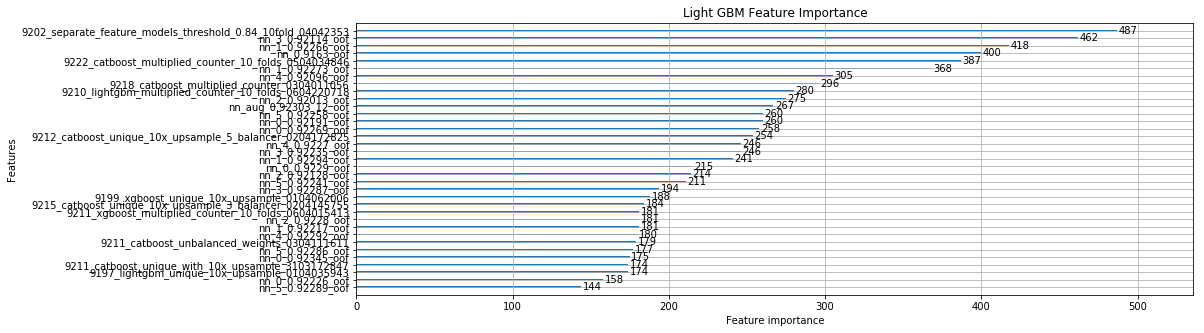

In [238]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 5))
lgb.plot_importance(model, max_num_features=len(cols), ax=ax)
plt.title("Light GBM Feature Importance")

In [270]:
w = [0,1]

df["blend"] = (w[1]*df["clf"])/sum(w)
dt["blend"] = (w[1]*dt["clf"])/sum(w)

print("\nROC AUC:", round(roc_auc_score(df.target, df["blend"]), 5))


ROC AUC: 0.92577


In [271]:
sub = pd.read_csv(intput_path+'sample_submission.csv.zip')
sub["target"] = dt["blend"]
sub.head()

,ID_code,target
0,test_0,0.126515
1,test_1,0.377153
2,test_2,0.334164
3,test_3,0.149924
4,test_4,0.053057


In [272]:
sub.to_csv(output_path + "best_blend_33.csv", index=False)

In [273]:
!ls ../output/

 best_auc_nn_0.pkl	  nn_0_0.92269_oof.npy	  nn_3_0.92235_test.npy
 best_auc_nn_1.pkl	  nn_0_0.92269_test.npy   nn_3_0.92287_oof.npy
 best_auc_nn_2.pkl	  nn_0_0.9229_oof.npy	  nn_3_0.92287_test.npy
 best_auc_nn_3.pkl	  nn_0_0.9229_test.npy	  nn_4_0.92096_oof.npy
 best_auc_nn.pkl	  nn_0_0.92345_oof.npy	  nn_4_0.92096_test.npy
 best_blend_10.csv	  nn_0_0.92345_test.npy   nn_4_0.9227_oof.npy
 best_blend_13.csv	  nn_0.9163_oof.npy	  nn_4_0.9227_test.npy
 best_blend_19.csv	  nn_0.9163_test.npy	  nn_4_0.92292_oof.npy
 best_blend_25.csv	  nn_1_0.92217_oof.npy	  nn_4_0.92292_test.npy
 best_blend_33.csv	  nn_1_0.92217_test.npy   nn_5_0.92241_oof.npy
 best_blend_7.csv	  nn_1_0.92266_oof.npy	  nn_5_0.92241_test.npy
 best_blend_8.csv	  nn_1_0.92266_test.npy   nn_5_0.92258_oof.npy
 best_blend.csv		  nn_1_0.92273_oof.npy	  nn_5_0.92258_test.npy
'!cat_0.91558_oof.npy'	  nn_1_0.92273_test.npy   nn_5_0.92286_oof.npy
'!cat_0.91558_test.npy'   nn_1_0.92294_oof.npy	  nn_5_0.92286_test.npy
 cat_0.91617_oof.

In [274]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../output/best_blend_33.csv -m "0.92577 10-folds reg"

100%|██████████████████████████████████████| 6.17M/6.17M [00:05<00:00, 1.14MB/s]
Successfully submitted to Santander Customer Transaction Prediction

In [319]:
res = 0
ans = {}
for i in range(6):
    with open(f"../output/hpo_logs_{i}.json" ,"r") as f:
        for item in f.readlines():
            d = eval(item)
            ans[d["target"]] = d["params"]
            if d["target"]>=res:
                res = d["target"]
                print(i, res, d["params"])


0 0.92209 {'batch_size': 10839.820336258967, 'enc_hidden_layer_k': 3.0031627823034683, 'lr': 0.006424870384644795, 'lr_sheduler_factor': 0.5359065463975176, 'lr_sheduler_patience': 8.083857592066856, 'nn_encoder_out': 68.13047017599905, 'upsampling_class_balancer': 5.50069769010154, 'upsampling_times': 18.160141013295355, 'use_bn': 0.9636627605010293, 'use_dropout': 0.3834415188257777}
0 0.92237 {'batch_size': 10498.497817036341, 'enc_hidden_layer_k': 0.6901829591873877, 'lr': 0.002799968724067601, 'lr_sheduler_factor': 0.11481743556849118, 'lr_sheduler_patience': 12.524372440289048, 'nn_encoder_out': 30.153221925434213, 'upsampling_class_balancer': 4.762813445575222, 'upsampling_times': 18.777381988915046, 'use_bn': 0.7044144019235328, 'use_dropout': 0.03183892953130785}
2 0.92239 {'batch_size': 13656.164267726457, 'enc_hidden_layer_k': 0.9688397286009185, 'lr': 0.00882024963788871, 'lr_sheduler_factor': 0.6990223026214836, 'lr_sheduler_patience': 12.583027849188971, 'nn_encoder_out':

In [320]:
for score in sorted(ans)[-4:]:
    print(score, ans[score])

0.92232 {'batch_size': 11256.031910244776, 'enc_hidden_layer_k': 0.5894282964739246, 'lr': 0.006959818173414933, 'lr_sheduler_factor': 0.4100187406986252, 'lr_sheduler_patience': 8.964885584814152, 'nn_encoder_out': 47.34152536372185, 'upsampling_class_balancer': 4.806975210413124, 'upsampling_times': 12.366624390515128, 'use_bn': 0.9729106898748249, 'use_dropout': 0.11277621523807146}
0.92235 {'batch_size': 16365.41943965368, 'enc_hidden_layer_k': 3.8431734367223815, 'lr': 0.009692571721568191, 'lr_sheduler_factor': 0.3775880090390893, 'lr_sheduler_patience': 5.107461172534069, 'nn_encoder_out': 97.68901245625834, 'upsampling_class_balancer': 2.0733130945474674, 'upsampling_times': 19.455715376700535, 'use_bn': 0.6390319975286751, 'use_dropout': 0.10273932337293801}
0.92237 {'batch_size': 10498.497817036341, 'enc_hidden_layer_k': 0.6901829591873877, 'lr': 0.002799968724067601, 'lr_sheduler_factor': 0.11481743556849118, 'lr_sheduler_patience': 12.524372440289048, 'nn_encoder_out': 30.1

In [326]:
sorted(ans)[-4]

0.92232